In [49]:
from transformers import PaliGemmaForConditionalGeneration,PaliGemmaProcessor,SiglipModel
from safetensors.torch import load_file
from PIL import Image

import re
import torch
from PIL import ImageDraw, ImageFont

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [50]:
def draw_paligemma_boxes(image, model_output, width=3):
    img = image.copy()
    draw = ImageDraw.Draw(img)
    W, H = img.size
    colors = {
        "molar": "red",
        "premolar": "blue", 
        "canine": "green",
        "incisor": "orange",
        "unknown": "grey"
    }
    pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s*([^;<]+)"
    matches = re.findall(pattern, model_output)
    for ymin, xmin, ymax, xmax, label in matches:
        ymin = int(ymin)
        xmin = int(xmin)
        ymax = int(ymax)
        xmax = int(xmax)
        x1 = xmin / 1023 * W
        y1 = ymin / 1023 * H
        x2 = xmax / 1023 * W
        y2 = ymax / 1023 * H
        label_lower = label.strip().lower()
        color = colors.get(label_lower, "grey")
        draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
        draw.text((x1, y1 - 10), label.strip(), fill=color)
    return img

In [94]:
model = PaliGemmaForConditionalGeneration.from_pretrained("justacoderwhocodes/paligemma-dental-bounding-boxes",dtype=torch.bfloat16) #
processor = PaliGemmaProcessor.from_pretrained("google/paligemma2-3b-pt-448",dtype=torch.bfloat16)
medsiglip = SiglipModel.from_pretrained("google/medsiglip-448",dtype=torch.bfloat16)

Loading weights: 100%|██████████| 888/888 [00:04<00:00, 198.48it/s, Materializing param=vision_model.post_layernorm.weight]                      


In [95]:
# model = PaliGemmaForConditionalGeneration.from_pretrained("trained_1000_steps",dtype=torch.bfloat16)

In [96]:
# medsiglip_state_dict = medsiglip.vision_model.state_dict()
# head_keys = [key for key in medsiglip_state_dict.keys() if 'head' in key]
# filtered_state_dict_no_head = {
#     k: v for k, v in medsiglip_state_dict.items() 
#     if not k.startswith("head.")
# }

In [97]:
# model.model.vision_tower.vision_model.load_state_dict(filtered_state_dict_no_head, strict=True)

In [98]:
model = model.to("mps")
model = model.eval()

In [123]:
image = Image.open("dataset_mixed_bbox/opg_123.jpg")
prompt = "<image><bos>detect canine; detect incisor; detect molar; detect premolar;"

In [124]:
inputs = processor(images=image,text=prompt,return_tensors="pt")

In [125]:
for k in inputs:
    inputs[k] = inputs[k].to("mps")

In [126]:
temp = model.generate(**inputs,max_new_tokens=384)
result = processor.decode(temp,skip_special_tokens=False)

In [127]:
print(result[0].replace("<image>",""))

<bos><bos>detect canine; detect incisor; detect molar; detect premolar;
<loc0407><loc0226><loc0501><loc0272> molar; <loc0474><loc0427><loc0576><loc0466> incisor; <loc0470><loc0459><loc0576><loc0497> incisor; <loc0463><loc0498><loc0571><loc0534> incisor; <loc0463><loc0538><loc0566><loc0583> incisor; <loc0440><loc0603><loc0552><loc0646> premolar; <loc0440><loc0643><loc0551><loc0691> molar; <loc0427><loc0705><loc0526><loc0757> molar; <loc0524><loc0719><loc0592><loc0795> molar; <loc0565><loc0613><loc0656><loc0675> premolar; <loc0569><loc0583><loc0662><loc0625> premolar; <loc0573><loc0552><loc0662><loc0594> canine; <loc0577><loc0521><loc0649><loc0553> incisor; <loc0583><loc0497><loc0647><loc0521> incisor; <loc0583><loc0469><loc0652><loc0495> incisor; <loc0579><loc0444><loc0651><loc0475> incisor; <loc0572><loc0409><loc0667><loc0450> canine; <loc0567><loc0380><loc0655><loc0419> premolar; <loc0560><loc0331><loc0594><loc0375> premolar; <loc0528><loc0245><loc0626><loc0336> molar; <loc0518><loc02

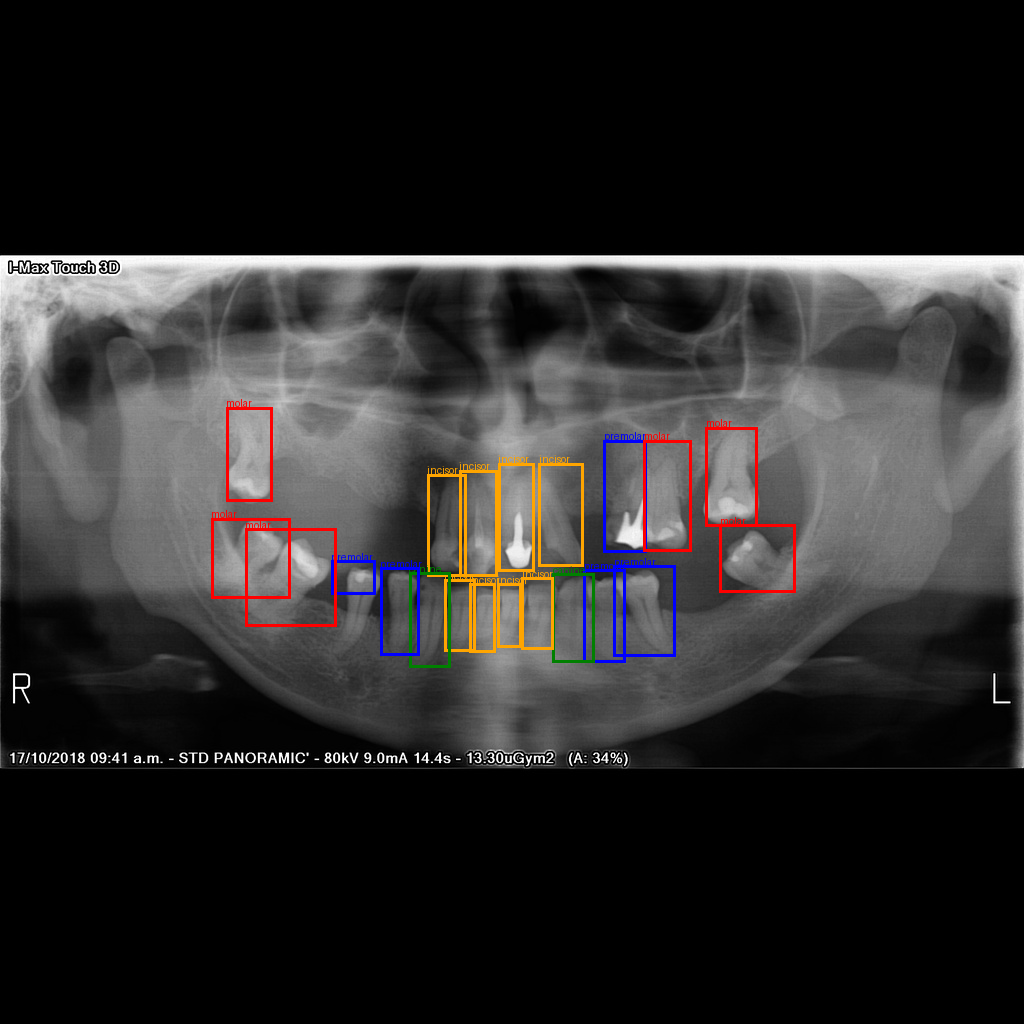

In [128]:
draw_paligemma_boxes(image,result[0])

From mixed trained model (panoramic_img128)

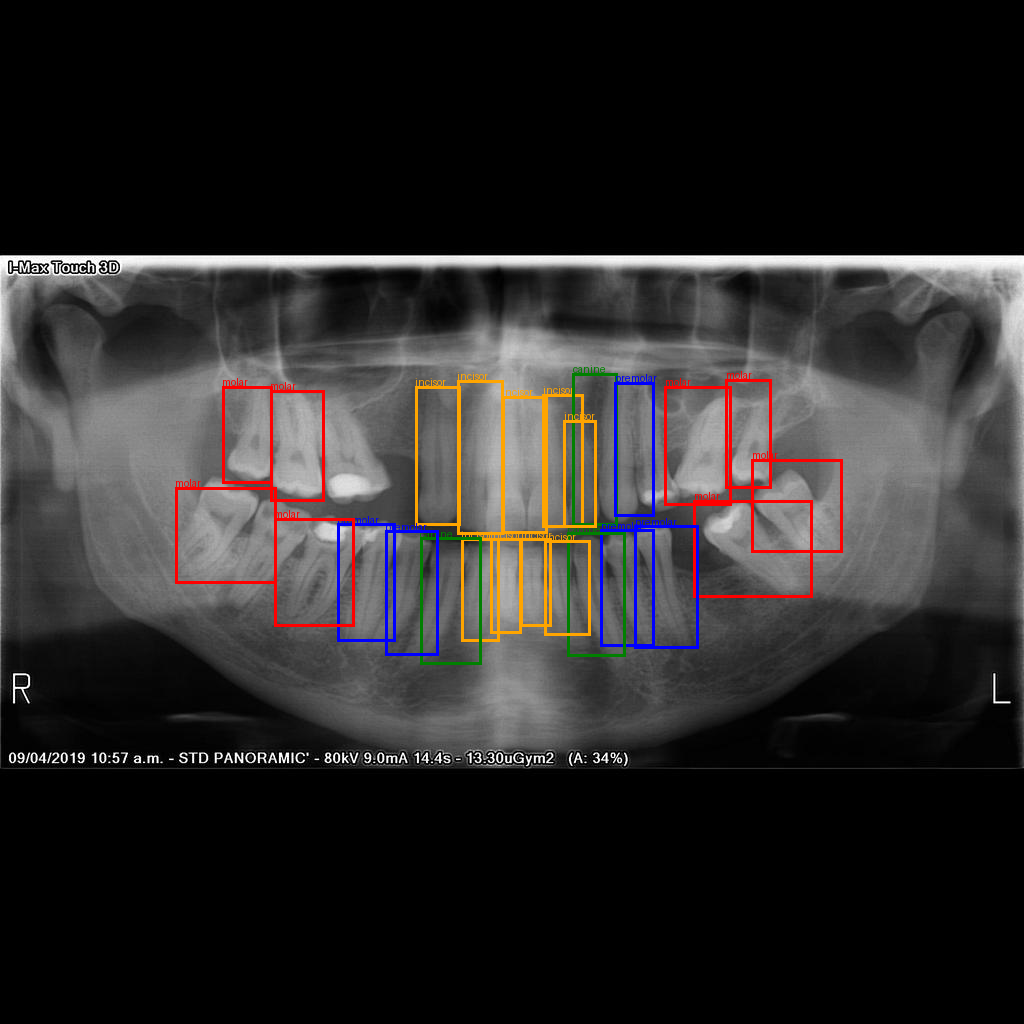

In [ ]:
draw_paligemma_boxes(image,result[0]) #img128